  site_id  total_power_consumption
0  Site_A                     95.8


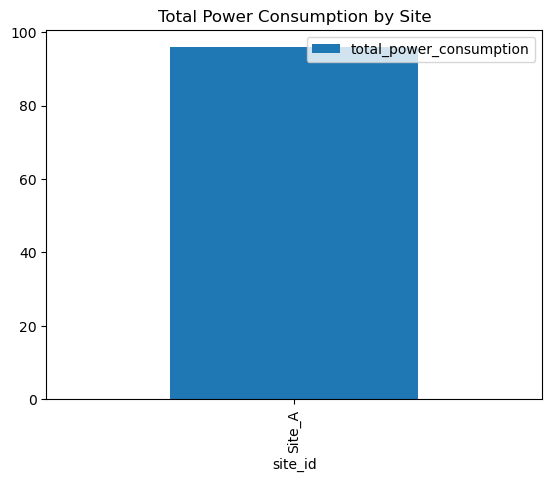

  site_id meter_id  total_power_usage
0  Site_A  Meter_1               50.5
1  Site_A  Meter_2               45.3


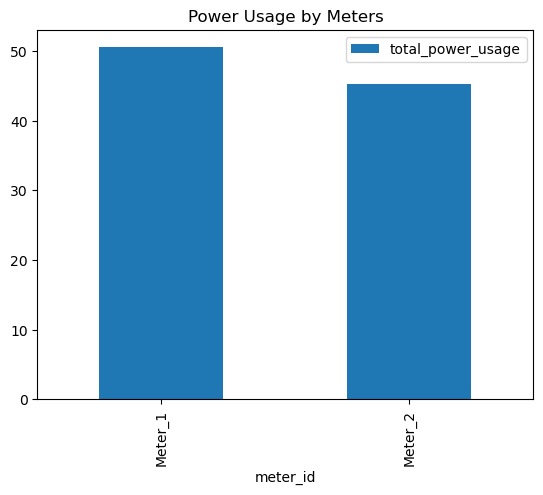

Empty DataFrame
Columns: [meter_id, missing_timestamps]
Index: []


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = "iot_sensor_data.db"
conn = sqlite3.connect(db_path)

query_total_power = """
SELECT site_id, SUM(sensor_value) AS total_power_consumption
FROM sensor_data
WHERE sensor_name = 'power_consumption'
GROUP BY site_id;
"""

total_power_df = pd.read_sql_query(query_total_power, conn)
total_power_df.to_csv("total_power_consumption.csv", index=False)
print(total_power_df)

total_power_df.plot(x='site_id', y='total_power_consumption', kind='bar', title='Total Power Consumption by Site')
plt.savefig('total_power_consumption.png')
plt.show()

query_highest_meter = """
SELECT site_id, meter_id, SUM(sensor_value) AS total_power_usage
FROM sensor_data
WHERE sensor_name = 'power_consumption'
GROUP BY site_id, meter_id
ORDER BY site_id, total_power_usage DESC;
"""

highest_power_meters_df = pd.read_sql_query(query_highest_meter, conn)
highest_power_meters_df.to_csv("highest_power_meters.csv", index=False)
print(highest_power_meters_df)

highest_power_meters_df.plot(x='meter_id', y='total_power_usage', kind='bar', title='Power Usage by Meters')
plt.savefig('highest_power_meters.png')
plt.show()

query_missing_timestamps = """
SELECT meter_id, COUNT(*) AS missing_timestamps
FROM (
    SELECT meter_id, timestamp,
           LAG(timestamp) OVER (PARTITION BY meter_id ORDER BY timestamp) AS prev_timestamp
    FROM sensor_data
)
WHERE prev_timestamp IS NOT NULL AND (JULIANDAY(timestamp) - JULIANDAY(prev_timestamp)) * 24 * 60 > 5
GROUP BY meter_id;
"""

missing_timestamps_df = pd.read_sql_query(query_missing_timestamps, conn)
missing_timestamps_df.to_csv("missing_timestamps.csv", index=False)
print(missing_timestamps_df)

conn.close()
